# Hierarchical Boundary Coefficient Clustering

HBCC is a boundary-based clustering algorithm. The intuition is as follows: (1)
points within a clusters have near neighbors on all sides, and (2) points
in-between clusters or on the edge of a cluster predominantly have neighbors in
the direction of the cluster's core. HBCC uses Vandaele et al.'s boundary
coefficient to compute a cluster hierarchy and uses HDBSCAN's principled
density-based cluster selection strategies to extract clusters. 

The relation between the boundary coefficient and local density is not
completely clear to me yet. Their main difference is that density only considers
how far away neighbors are, while the boundary coefficient also considers how
spread out they are. Typically, local density maxima occur towards the center of
a cluster (due to some Gaussian-like spread around a true centre). In that case,
the boundary coefficient agrees, neighbors are spread out around the local
density maximum. However, the boundary coefficient can have local minima in
places where there is not density maximum, allowing it to detect clusters that
are not detectable using density-based clustering.

To demonstrate this, consider a three-point star in which density decrease along
its arms:


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from fast_hbcc import HBCC
from fast_hdbscan import HDBSCAN
from sklearn.utils import shuffle

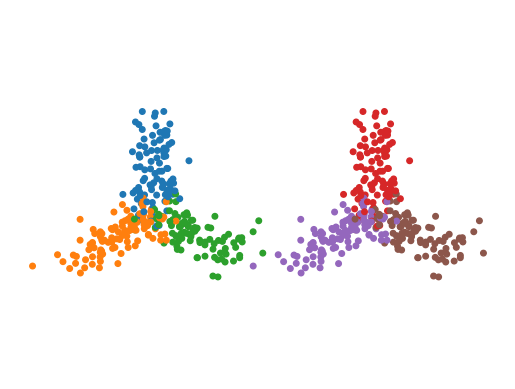

In [17]:
def make_star(num_samples=100, length=2, scale=0.02):
    """Creates a star with three branches.

    Datapoints are spaced logarithmically along the branch length,
    with the high-density part at the start of the branches.
    """

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(length)
    x = np.exp(np.linspace(0, max_exp, num_samples)) - 1
    branch = np.hstack((x[None].T, np.zeros((x.shape[0], 1), dtype=x.dtype)))
    X = np.vstack(
        (
            rotate(branch, theta=np.pi / 2),
            rotate(branch, theta=2 * np.pi / 3 + np.pi / 2),
            rotate(branch, theta=4 * np.pi / 3 + np.pi / 2),
        )
    )
    X += np.random.normal(scale=scale, size=X.shape)
    y = np.repeat([0, 1, 2], num_samples)
    X, y = shuffle(X, y)
    return X, y


X, y = make_star(length=1.5, scale=0.1 * np.sqrt(1 / 2))
X = np.concat((X, X + np.array([1.2, 0])))
y = np.concat((y, y + y.max() + 1))

kwargs = dict(s=16, cmap='tab10', vmin=0, vmax=9)
plt.scatter(*X.T, c=y, **kwargs)
plt.axis('equal')
plt.axis('off')
plt.show()


## Density based clustering 

Density-based clustering in general cannot detect the branches as clusters. For
example, hdbscan only finds the two stars when configured to look for leaf
clusters with at least 60 points.

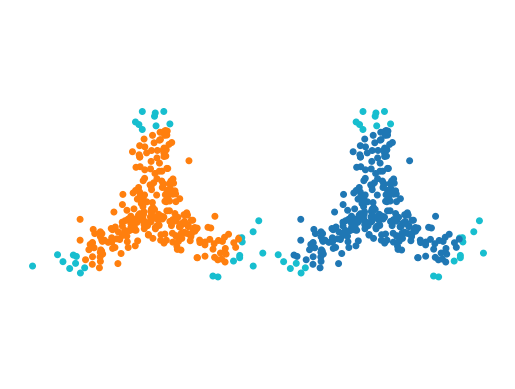

In [22]:
hdbscan = HDBSCAN(
  min_cluster_size=60,
  cluster_selection_method='leaf'
).fit(X)
plt.scatter(*X.T, c=hdbscan.labels_%10, **kwargs)
plt.axis('equal')
plt.axis('off')
plt.show()

Decreasing the minimum cluster size does not help, because the branches are not
properly represented in the cluster hierarchy and density profile:

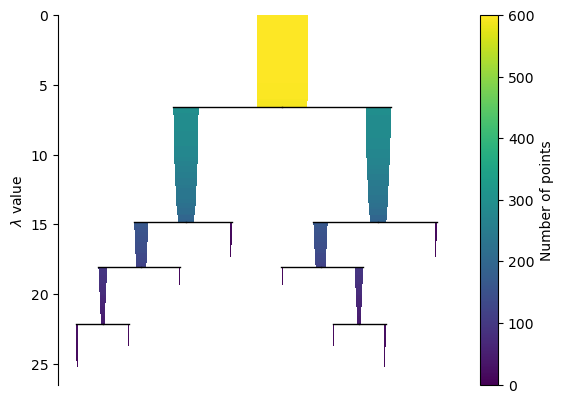

In [23]:
HDBSCAN(min_cluster_size=10).fit(X).condensed_tree_.plot()
plt.show()

## Boundary-based clustering

Boundary-based clustering is able to find the branches as clusters because there is a (slight) local maximum on the branch ends:

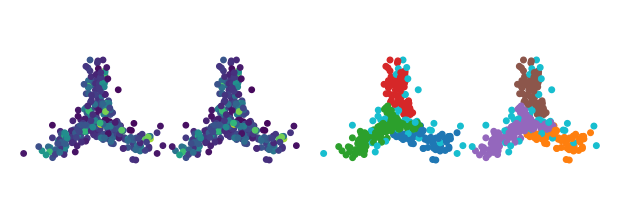

In [18]:
hbcc = HBCC(min_cluster_size=40, cluster_selection_method="leaf").fit(X)

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=1 / hbcc.boundary_coefficient_, s=15)
plt.axis("equal")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=hbcc.labels_ % 10, **kwargs)
plt.axis("equal")
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

Consequently, the branches are properly reflected in the condensed hierarchy:

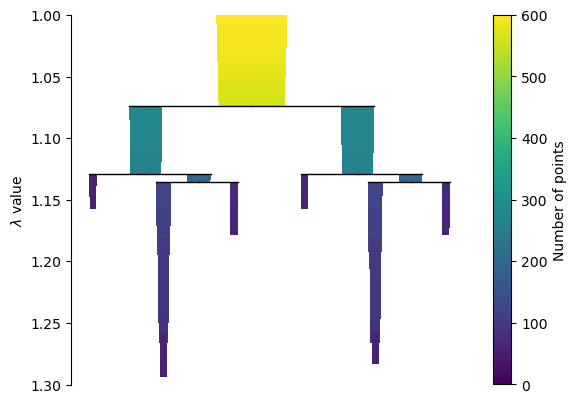

In [19]:
hbcc.condensed_tree_.plot()
plt.ylim(1.3, 1.0)
plt.show()

## Limitations

Detecting noise points is less effective using the boundary coefficient than a
local density estimate. CDC [4] addressed this issue by running a
noise-detection pre-processing step. HBCC does not have such a step (yet). As a
result, noise points can form clusters or create connections between clusters in
more complicated datasets.

In [20]:
data = np.load('data/flareable/flared_clusterable_data.npy')

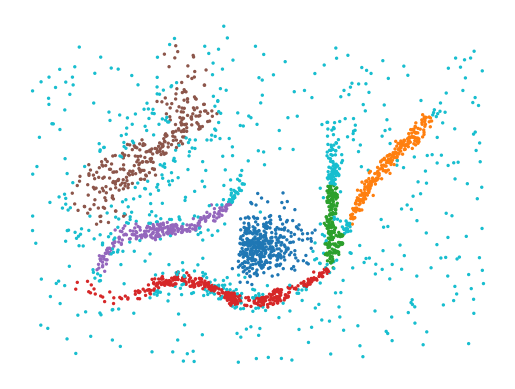

In [9]:
c = HBCC(
    num_hops=4,
    min_samples=10,
    min_cluster_size=100,
    cluster_selection_method="leaf",
).fit(data)
kwargs["s"] = 2
plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
plt.axis("off")
plt.show()

Tuning the boundary coefficient parameters can improve results. However, the
interaction between `num_points` and `min_samples` can be difficult to predict.
Both parameters influence the computed boundary coefficient profile.

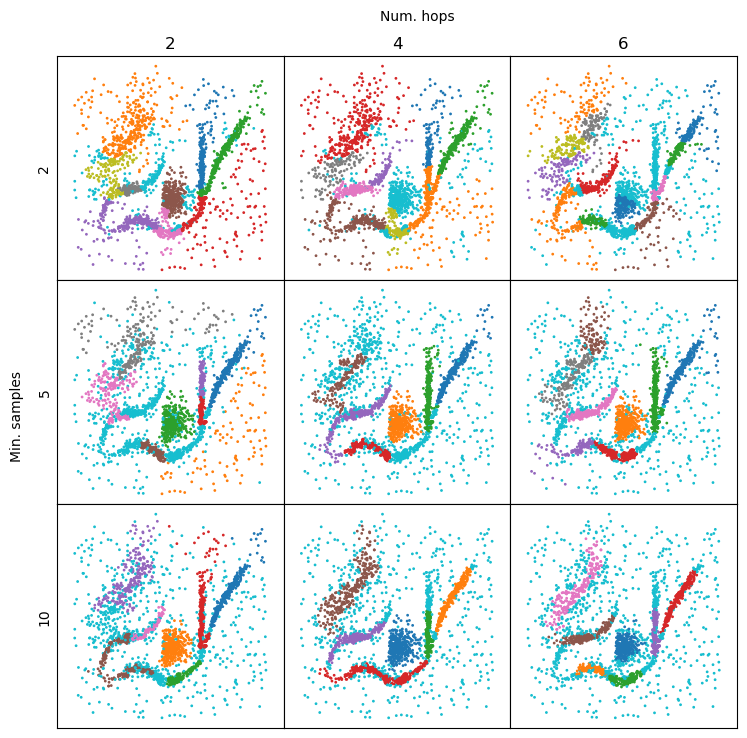

In [10]:
hops = [2, 4, 6]
samples = [2, 5, 10]
kwargs["s"] = 1
plt.figure(figsize=(8, 8))
cnt = 1
for samples in samples:
    for hop in hops:
        c = HBCC(
            num_hops=hop,
            min_samples=samples,
            min_cluster_size=100,
            cluster_selection_method="leaf",
        ).fit(data)
        plt.subplot(3, 3, cnt)
        if samples == 2:
            plt.title(hop)
        if hop == 2:
            plt.ylabel(samples)
        plt.axis("equal")
        plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
        plt.xticks([])
        plt.yticks([])
        cnt += 1
plt.text(
    0,
    0.5,
    "Min. samples",
    rotation=90,
    va="center",
    ha="center",
    transform=plt.gcf().transFigure,
)
plt.text(
    0.5,
    1,
    "Num. hops",
    va="center",
    ha="center",
    transform=plt.gcf().transFigure,
)
plt.subplots_adjust(left=0.05, top=0.95, wspace=0, hspace=0)
plt.show()